# Path Planning On a Grid with Motion Primitives

In this lab your task is to implement `A*` and its suboptimal version - `WA*` (Weighted A*) to solve path planning problems on a grid for an agent that moves over the motions primitives. There are two types of motion primitives - move and rotation. each move action is given in the form of two parametric equations describing how the coordinates `x` and `y` change depending on time `t`. Rotation actions are more trivial and have only the duration variable.

As well as in the previos lab the search space state is considered by the four variables - `<i, j, v, o>`, where `i` and `j` are the cell's coordinates, `v` - velocity speed, `o` - orientation. It's assumed that the agent have two velocity speeds - 1 and 0. The actions, that the agent can perform depend on its orientation and velocity speed. Rotation actions are allowed only when the velocity speed is 0.

You can use the implementation of `A*` you have created in the previous lab. You need to modify it in such a way, that it generates the successors depending on the actions that the agent can actually perform. You also need to create a method that checks whether the move action doesn't lead to collisions with static obstacles.

<img src="./Image/fig1.png" alt="Drawing" style="width: 1000px;"/>

Run every cell of the notebook, completing the tasks described in them. Good luck!

In [24]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from sys import float_info
import xml.etree.ElementTree as ElementTree
from copy import copy
EPS = float_info.epsilon
%matplotlib inline

### Grid map representation 

Square grid map class represents the environment for our moving agent

- width -- the number of columns in the grid
- height -- the number of rows in the grid
- cells -- the binary matrix, that represents the grid. 0 - cell is traversable, 1 - cell is blocked

In [25]:
class Map:

    # 
    def __init__(self):
        '''
        Default constructor
        '''

        self.width = 0
        self.height = 0
        self.cells = []
    

    def ReadFromString(self, cellStr, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self.width = width
        self.height = height
        self.cells = [[0 for _ in range(width)] for _ in range(height)]
        cellLines = cellStr.split("\n")
        i = 0
        j = 0
        for l in cellLines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self.cells[i][j] = 0
                    elif c == '#':
                        self.cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def SetGridCells(self, width, height, gridCells):
        '''
        Initialization of map by list of cells.
        '''
        self.width = width
        self.height = height
        self.cells = gridCells


    def inBounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self.width) and (0 <= i < self.height)
    

    def Traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self.cells[i][j]

    def CheckAction(self, i, j, cells):
        '''
        Check all the cells affected by the action for boundness and traversability
        '''
        for cell in cells:
            if not self.inBounds(i + cell[0], j + cell[1]) or not self.Traversable(i + cell[0], j + cell[1]):
                return False
        return True
    
    #Note that we don't have getNeighbors method as now they are generated from motion primitives

## Motion Primitives

The following class loads motion primitives from the XML-file of the predifined class.\
Each motion primitive is described by the `start state` (i, j, speed, orientaion), `end state`, `duration` and `ID`. Primitives corresponding to the move actions also have the coefficients of the parametric equations that describe how the agent actually moves during the action. To get the agents' position at some time moment $t$ $(0 \leq t \leq duration)$, the one needs to calculate the values\
$i = b_1+tb_2+t^2b_3+t^3b_4$; $j = a_1+ta_2+t^2a_3+t^3a_4$ \
During the search proccess it's necessary to store not only the parent, but also the ID of the action that was performed. Furtherly these actions' IDs are used to restore the trajectory and for visualization.

In [46]:
def dictify(r, root=True):
    if root:
        return {r.tag : dictify(r, False)}
    d=copy(r.attrib)
    for x in r.findall("./*"):
        if x.tag not in d:
            d[x.tag]=[]
        d[x.tag].append(dictify(x,False))
    return d

class MotionPrimitive:
    def __init__(self):
        self.startState = [0, 0, None, None] #i, j, velocity speed, orientation
        self.endState = [None, None, None, None]
        self.iCoefs = [] # coeeficients of the equation
        self.jCoefs = []
        self.duration = 0
        self.id = None
        self.cells = []
    
    def getPoints(self):
        if self.endState[0] == 0 and self.endState[1] == 0: #if it's a rotation action
            return []
        points = []
        for t in range(0, int(self.duration * 100000), 1000):
            i = self.iCoefs[0] + self.iCoefs[1] * t/10000.0 + self.iCoefs[2] * math.pow(t/10000.0, 2) + self.iCoefs[3] * math.pow(t/10000.0, 3)
            j = self.jCoefs[0] + self.jCoefs[1] * t/10000.0 + self.jCoefs[2] * math.pow(t/10000.0, 2) + self.iCoefs[3] * math.pow(t/10000.0, 3)
            points.append((i, j))
        points.append((self.endState[0], self.endState[1]))
        return points


class MotionPrimitives:
    def __init__(self):
        self.actions = dict()
    
    def Load(self, fileName):
        tree = ElementTree.parse(fileName)
        data = dictify(tree.getroot(), False)
        for actions in data['actions']:
            primsZero = []
            primsOne = []
            for move in actions['move']:
                mp = MotionPrimitive()
                mp.duration = float(move['Tf'])
                mp.startState = [0, 0, int(move['v0']), int(move['phi0'])]
                mp.endState = [int(move['yf']), int(move['xf']), int(move['vf']), int(move['phif'])]
                mp.jCoefs = [float(move['a1']), float(move['a2']), float(move['a3']), float(move['a4'])]
                mp.iCoefs = [float(move['b1']), float(move['b2']), float(move['b3']), float(move['b4'])]
                mp.cells = self.CalculateCells(mp)
                mp.id = int(move['id'])
                if mp.startState[2] == 0:
                    primsZero.append(mp)
                else:
                    primsOne.append(mp)                        
            for rot in actions['rotate']:
                mp = MotionPrimitive()
                mp.duration = float(rot['Tf'])
                mp.startState = [0, 0, 0, int(rot['phi0'])]
                mp.endState = [0, 0, 0, int(rot['phif'])]
                mp.cells = [(0, 0)]
                mp.id = int(rot['id'])
                primsZero.append(mp)
            self.actions[(int(actions['move'][0]['phi0']), 0)] = primsZero
            self.actions[(int(actions['move'][0]['phi0']), 1)] = primsOne
    
    
    def CalculateCells(self, action):
        cells = set()
        for i in action.getPoints():
          cells.add((int(round(i[0])), int(round(i[1]))))
#TODO
        return cells

### Search Node Representation



In [27]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node 

    You might want to add other fields, methods for Node, depending on how you prefer to implement OPEN/CLOSED further on
    '''

    def __init__(self, i, j, speed=None, orientation=None, g = 0, h = 0, F = None, parent = None, action_id = -1, hweight = 1):
        self.i = i
        self.j = j
        self.g = g
        self.h = h * hweight
        self.speed = speed
        self.orientation = orientation
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent
        self.action_id = action_id
    
    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j) and (self.speed == other.speed) and (self.orientation == other.orientation)
    
    def __lt__(self, other): #self < other (self has higher priority)
        return self.F < other.F or (abs(self.F - other.F) < EPS and (self.g > other.g))

### Visualization

In [28]:
def Draw(gridMap : Map, start : Node = None, goal : Node = None, path : list = None, nodesExpanded = None, nodesOpened = None, primitives = MotionPrimitives):
    '''
    Auxiliary function that visualizes the enviromnet, the path and OPEN and CLOSED.
    '''
    k = 15
    hIm = gridMap.height * k
    wIm = gridMap.width * k
    im = Image.new('RGB', (wIm, hIm), color = 'white')
    draw = ImageDraw.Draw(im)
    for i in range(gridMap.height):
        for j in range(gridMap.width):
            if(gridMap.cells[i][j] == 1):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodesOpened is not None:
        if (type(nodesOpened) == type(YourOpen())):
            for h, node in nodesOpened.elements.items():
                draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)
        else:
            for node in nodesOpened:
                draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodesExpanded is not None:
        if (type(nodesExpanded) == type(YourClosed())):
            for h, node in nodesExpanded.elements.items():
                draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=( 131, 145, 146 ), width=0)
        else:
            for node in nodesExpanded:
                draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=( 131, 145, 146 ), width=0)

    allpoints = []
    if path is not None:
        for step in path:
            if (step is not None):
                if step.action_id > 0:
                    for actions in primitives.actions.values():
                        for action in actions:
                            if action.id == step.action_id:
                                points = action.getPoints()
                                break
                    for point in points:
                        p = [(prevstep.j + 0.5 + point[1])*k, (prevstep.i + 0.5 + point[0])*k]
                        allpoints.append((p[0], p[1]))
                prevstep = step
    draw.line(allpoints, fill='blue', width=int(max(1,gridMap.width/100)))
    if (start is not None) and (gridMap.Traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (gridMap.Traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)


    fig, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))

### Implementing OPEN and CLOSED
Efficient implementation of OPEN and CLOSED is crucial for any search algorithm. Below you may find basic implementations that use lists to store the elements of OPEN and CLOSED. This is not very efficient. Your task is to create your own implementations.

It's a good idea to modify CLOSED first (as it is pretty straghtforward to do so). Then check that everything is OK, i.e. the search algorithms work faster and the result is correct. Then proceed to modifying OPEN (which is not that trivial as might seem).

PS: You may wish to add additional fields, methods, method-arguments etc. to your implementations.


In [29]:
class OpenBase:

    def __init__(self):
        pass


    def __len__(self):
        pass


    def __iter__(self):
        pass


    def isEmpty(self):
        '''
        isEmpty should inform whether the OPEN is exhausted or not in the former case the search main loop should be interrupted
        '''
        pass


    def AddNode(self, node : Node, *args):
        '''
        AddNode is the method that puts (e.g. inserts or updates) the node to OPEN
        When implementing it do not forget to handle all possible cases:
         - node already in OPEN but the new g-value is better;
         - node already in OPEN but the new g-value is worse;
         - node is not in OPEN yet.
        '''
        pass


    def GetBestNode(self, *args):
        '''
        GetBestNode is the method that 
         i) finds the best node, i.e. the one with the lowest f-value (f=g+h) (for Dijkstra h=0),
         ii) removes it from OPEN and 
         iii) returns it
        '''
        pass



In [30]:
class OpenList (OpenBase):

    def __init__(self):
        self.elements = []
    

    def __iter__(self):
        return iter(self.elements)


    def __len__(self):
        return len(self.elements)


    def isEmpty(self):
        if len(self.elements) != 0:
            return False
        return True
    

    def GetBestNode(self, *args):
        bestF = math.inf
        bestCoord = 0
        for i in range(len(self.elements)):
            if self.elements[i].F < bestF:
                bestCoord = i
                bestF = self.elements[i].F
                
        best = self.elements.pop(bestCoord)
        return best
    

    def AddNode(self, node : Node, *args):
        for existingNode in self.elements:
            if existingNode == node:
                if existingNode.g > node.g:
                    existingNode.g = node.g
                    existingNode.F = node.F
                    existingNode.parent = node.parent
                    existingNode.action_id = node.action_id
                    return
                else:
                    return
        self.elements.append(node)
        return


In [31]:
class ClosedBase:

    def __init__(self):
        pass


    def __iter__(self):
        pass
    

    def __len__(self):
        pass
    
    
    def AddNode(self, item : Node):
        pass


    def WasExpanded(self, item : Node):
        pass



In [32]:
class ClosedList (ClosedBase):

    
    def __init__(self):
        self.elements = []


    def __iter__(self):
        return iter(self.elements)
    

    def __len__(self):
        return len(self.elements)
    

    def AddNode(self, item : Node):
        '''
        AddNode is the method that inserts the node to CLOSED
        '''
        self.elements.append(item)
     
     
    def WasExpanded(self, item : Node):
        '''
        WasExpanded is the method that checks if a node has been expanded
        '''
        return item in self.elements

In [33]:
class YourOpen (OpenBase):

    
    def __init__(self):
        self.elements = dict()
        self.sortF = dict()
    
    def __iter__(self):
        return iter(self.elements)
    
    def __len__(self):
         return len(self.elements)

    def isEmpty(self):
        return len(self.elements) == 0

    def AddNode(self,node:Node, *args):
            el = self.elements.get(((node.i, node.j), (node.speed, node.orientation)))
            if el:
                if el.g > node.g:
                    mn = el.F
                    self.elements[((node.i, node.j), (node.speed, node.orientation))] = Node(node.i, node.j, node.speed, node.orientation, node.g, node.h, node.F, node.parent)
                    self.sortF[mn].remove(((node.i, node.j), (node.speed, node.orientation)))
                    if (len(self.sortF[mn]) == 0):
                        self.sortF.pop(mn)
    
                    if self.sortF.get(node.F):
                        self.sortF.update({node.F: self.sortF[node.F] + [((node.i, node.j), (node.speed, node.orientation))]})
                    else:
                        self.sortF.update({node.F: [((node.i, node.j), (node.speed, node.orientation))]})
                return
            self.elements.update({((node.i, node.j), (node.speed, node.orientation)): node})
    
            if self.sortF.get(node.F):
                self.sortF.update({node.F: self.sortF[node.F] + [((node.i, node.j), (node.speed, node.orientation))]})
            else:
                self.sortF.update({node.F: [((node.i, node.j), (node.speed, node.orientation))]})
            return

    def GetBestNode(self, *args):
         mn = min(self.sortF)
         k = self.sortF[mn][0]
         if (len(self.sortF[mn])) == 1:
               self.sortF.pop(mn)
         else:
               self.sortF.update({mn: self.sortF[mn][1:]})
         best = self.elements.pop(k)
         return best

In [34]:
class YourClosed (ClosedBase):
    

    def __init__(self):
        self.elements = dict()


    def __iter__(self):
        return iter(self.elements)
    

    def __len__(self):
        return len(self.elements)


    def AddNode(self, item : Node):
        self.elements.update({((item.i, item.j),(item.speed, item.orientation)): item})


    def WasExpanded(self, item : Node):
        return ((item.i, item.j),(item.speed, item.orientation)) in self.elements

## Weighted A* algorithm with velocity/orientation

In [35]:
def EuclideanDistance(i1, j1, i2, j2):
    return math.sqrt((i1 - i2)**2 + (j1 - j2)**2)

In [36]:
def WAStar(gridMap : Map, iStart : int, jStart : int, iGoal : int, jGoal : int, heuristicFunction = EuclideanDistance,
           openType = OpenList, closedType = ClosedList, mp = MotionPrimitives, hweight = 1.0):

    OPEN = openType()
    CLOSED = closedType()
    start = Node(iStart, jStart, 0, 0, hweight=hweight)
    OPEN.AddNode(start)
    while not OPEN.isEmpty():
        curNode = OPEN.GetBestNode()
        CLOSED.AddNode(curNode)
        if (((curNode.i, curNode.j) == (iGoal, jGoal)) and (curNode.speed == 0)):
            return (True, curNode, CLOSED, OPEN)
        if not (mp.actions.get((curNode.orientation, curNode.speed))):
            print((curNode.orientation, curNode.speed))
        neighbors = mp.actions[(curNode.orientation, curNode.speed)]
        for n in neighbors:
            if (gridMap.CheckAction(curNode.i, curNode.j, n.cells)):
                newNode = Node(curNode.i + n.endState[0], curNode.j + n.endState[1],
                               n.endState[2], n.endState[3] % 360)
                newNode.g = curNode.g + n.duration
                newNode.h = hweight * heuristicFunction(newNode.i, newNode.j, iGoal, jGoal)
                newNode.F = newNode.g + newNode.h
                newNode.parent = curNode
                newNode.action_id = n.id
                if CLOSED.WasExpanded(newNode):
                    continue
                OPEN.AddNode(newNode)
    return False, None, CLOSED, OPEN

### Validating the results


In [37]:
def MakePath(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [38]:
def ReadTaskFromFile(path):
    '''
    Reads map, start/goal positions and true value of path length between given start and goal from file by path. 
    '''

    tasksFile = open(path)
    count = 0
    height = int(tasksFile.readline())
    width = int(tasksFile.readline())
    cells = [[0 for _ in range(width)] for _ in range(height)]
    i = 0
    j = 0

    for l in tasksFile:
        j = 0
        for c in l:
            if c == '.':
                cells[i][j] = 0
            elif c == '#':
                cells[i][j] = 1
            else:
                continue
            
            j += 1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
                
        i += 1
        if(i == height):
            break
    
    iStart = int(tasksFile.readline())
    jStart = int(tasksFile.readline())
    iGoal = int(tasksFile.readline())
    jGoal = int(tasksFile.readline())
    cost = float(tasksFile.readline())
    return (width, height, cells, iStart, jStart, iGoal, jGoal, cost)

`Simpletest` tests the pathfing algorithm on a single simple instance, `Massivetest` - on a series of a move involved instances. Both tests assume that the search function fits the following pattern:


`Search(taskMap, start.i, start.j, goal.i, goal.j, *optional arguments*) -> (pathFound, lastState, CLOSED, OPEN)`, where

- taskMap -- grid
- start.i, start.j -- (i,j) coordinates of the start cell
- goal.i, goal.j -- (i,j) coordinates of the goal cell
- *optional arguments* -- additional parameters of the search function, passed with `*args`. Example of additional parameters you can see at Dijkstra and A* functions
- pathFound -- `True` if path was found, `False` otherwise
- lastState -- last state of the path. `None` if path was not found
- CLOSED -- CLOSED set (at the last step)
- OPEN -- OPEN set (at the last step)

In [39]:
from random import randint
import sys

def SimpleTest(SearchFunction, task, *args):
    '''
    SimpleTest runs SearchFunction on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task

    '''
    
    height = 15
    width = 30
    mapstr = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''

    taskMap = Map()
    taskMap.ReadFromString(mapstr, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29)]
    costs = [34.25, 25.4, 29.4, 20.78, 26.7, 26.4, 35.4876, 26.9376, 43.3628, 24.4, 44.1376, 39.2876, 31.0376 ,24.65, 32.6, 34.0252, 37.85, 27.6, 40.4697, 36.6897, 31.9876, 27.5, 32.65, 37.85, 38.2876]


    if (task is None) or not (0 <= task < 25):
        task = randint(0, 24)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    cost = costs[task]
    try:
        result = SearchFunction(taskMap, start.i, start.j, goal.i, goal.j, *args)
        nodesExpanded = result[2]
        nodesOpened = result[3]
        if result[0]:
            path = MakePath(result[1])
            correct = abs(float(path[1]) - float(cost)) < 1e-6
            Draw(taskMap, start, goal, path[0], nodesExpanded, nodesOpened, primitives)
            #print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct))
            print("Path found! Length: {:14.10f}. Nodes created: {:8d}. Number of steps: {:8d}. Correct: {:s}".format(path[1], len(nodesOpened) + len(nodesExpanded), len(nodesExpanded), str(correct)))
        else:
            print("Path not found!")

    except Exception as e:
        print("Execution error")
        tb = sys.exc_info()[2]
        print(e)
        raise e.with_traceback(tb)

In [40]:
def MassiveTest(SearchFunction, *args):
    '''
    MassiveTest runs SearchFunction on set of differnt tasks (from directory Data/) with *args as optional arguments and for every task displays one of these short reports:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task.
    
    Massive test return a dictionary with statistics of path finding. Dictionary contains next fields:
     - "corr" -- the correctness of every path length (True/False)
     - "len" -- the length of every path (0.0 if path not found)
     - "nc" -- the number of created nodes for every task execution
     - "st" -- the number of steps of algorithm for every task execution
    '''
    
    stat = dict()
    stat["corr"] = []
    stat["len"] = []
    stat["nc"] = []
    stat["st"] = []
    taskNum = 9
    taskMap = Map()
    for taskCount in range(taskNum):
        taskFileName = "Data/" + str(taskCount) + ".map"
        width, height, cells, iStart, jStart, iGoal, jGoal, cost = ReadTaskFromFile(taskFileName)
        taskMap.SetGridCells(width,height,cells)
        try:
            result = SearchFunction(taskMap, iStart, jStart, iGoal, jGoal, *args)
            nodesExpanded = result[2]
            nodesOpened = result[3]
            if result[0]:
                path = MakePath(result[1])
                stat["len"].append(path[1])
                correct = abs(float(path[1]) - float(cost)) < 1e-6
                stat["corr"].append(correct)
                #Draw(taskMap, Node(iStart, jStart), Node(iGoal, jGoal), path[0], nodesExpanded, nodesOpened, primitives)
                #print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct))
                print("Path found! Length: {:14.10f}. Nodes created: {:8d}. Number of steps: {:8d}. Correct: {:s}".format(path[1], len(nodesOpened) + len(nodesExpanded), len(nodesExpanded), str(correct)))
            else:
                print("Path not found!")
                stat["corr"].append(False)
                stat["len"].append(0.0)

            stat["nc"].append(len(nodesOpened) + len(nodesExpanded))
            stat["st"].append(len(nodesExpanded))

        except Exception as e:
            print("Execution error")
            tb = sys.exc_info()[2]
            print(e)
            raise e.with_traceback(tb)

    return stat

## Experimental evaluation

In [41]:
from google.colab import drive
drive.mount('/content/drive/')
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
 Data   Image   Lab3.ipynb  'Копия блокнота "lab3.ipynb"'


In [42]:
%cd /content/drive/My Drive/Planning/Lab3/
!ls

/content/drive/My Drive/Planning/Lab3
 Data   Image   Lab3.ipynb  'Копия блокнота "lab3.ipynb"'


In [43]:
'''
Before starting any runs we need to load motion primitives, i.e. actions that the agent can perform.
'''
primitives = MotionPrimitives()
primitives.Load('./Data/motion_primitives.xml')

Path found! Length:  34.2500000000. Nodes created:     2206. Number of steps:     1178. Correct: True
CPU times: user 129 ms, sys: 743 µs, total: 130 ms
Wall time: 134 ms
Path found! Length:  25.4000000000. Nodes created:     1009. Number of steps:      284. Correct: True
CPU times: user 57.2 ms, sys: 1.07 ms, total: 58.2 ms
Wall time: 65 ms
Path found! Length:  29.4000000000. Nodes created:      665. Number of steps:      166. Correct: True
CPU times: user 38.2 ms, sys: 0 ns, total: 38.2 ms
Wall time: 38.4 ms
Path found! Length:  20.7800000000. Nodes created:      540. Number of steps:      123. Correct: True
CPU times: user 34.3 ms, sys: 0 ns, total: 34.3 ms
Wall time: 35 ms
Path found! Length:  26.7000000000. Nodes created:      347. Number of steps:       89. Correct: True
CPU times: user 30.7 ms, sys: 1.61 ms, total: 32.4 ms
Wall time: 32.5 ms
Path found! Length:  26.4000000000. Nodes created:     1101. Number of steps:      320. Correct: True
CPU times: user 106 ms, sys: 2.87 ms,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

Path found! Length:  32.6500000000. Nodes created:     1998. Number of steps:      831. Correct: True
CPU times: user 103 ms, sys: 294 µs, total: 104 ms
Wall time: 102 ms
Path found! Length:  37.8500000000. Nodes created:     2558. Number of steps:     1433. Correct: True
CPU times: user 177 ms, sys: 0 ns, total: 177 ms
Wall time: 176 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Path found! Length:  38.2876000000. Nodes created:     2669. Number of steps:     1723. Correct: True
CPU times: user 185 ms, sys: 2.49 ms, total: 188 ms
Wall time: 187 ms


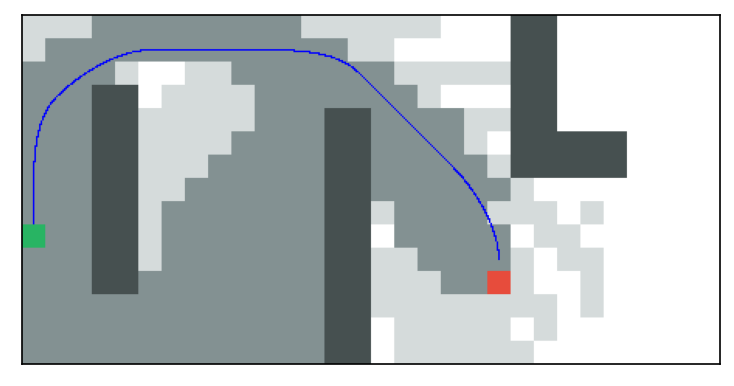

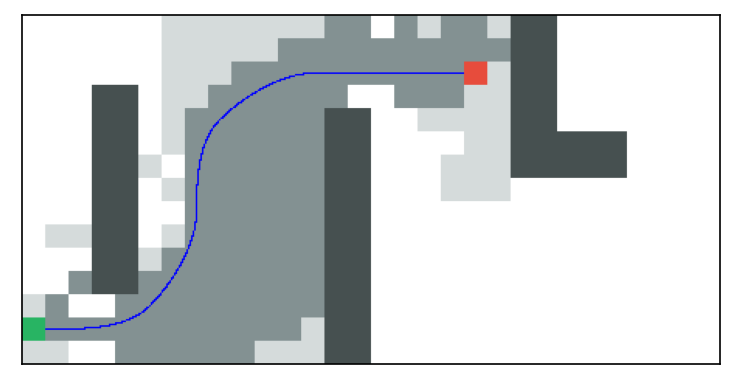

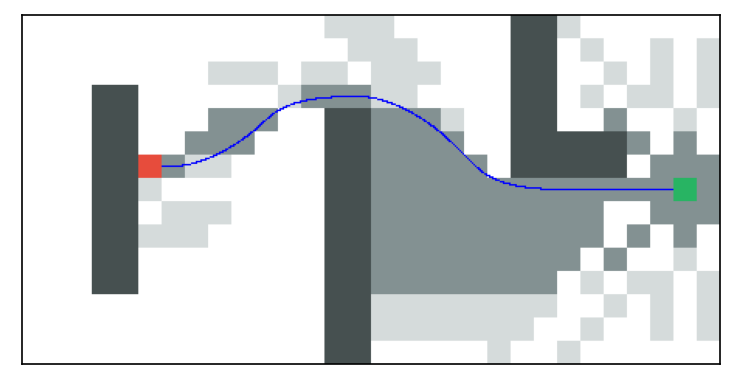

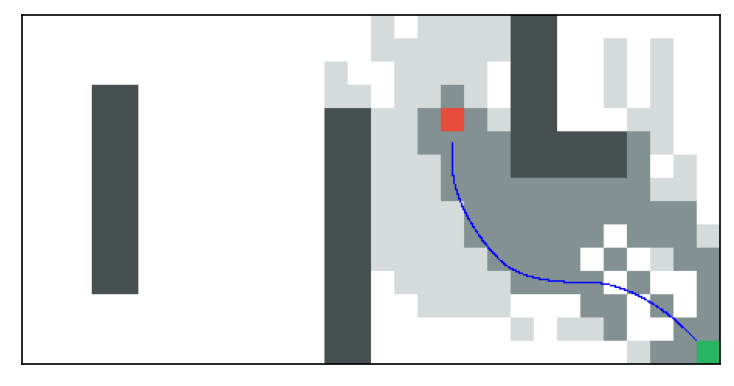

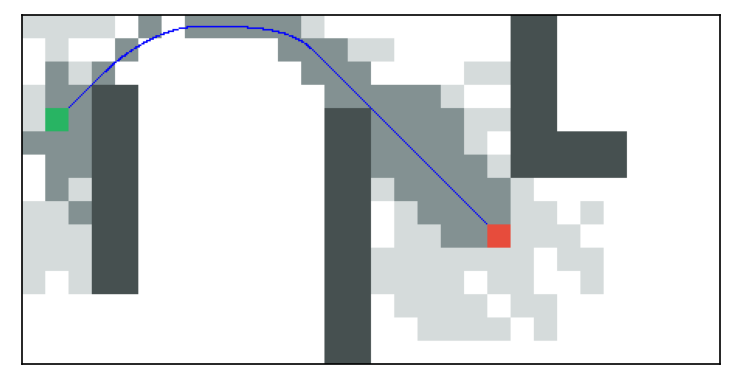

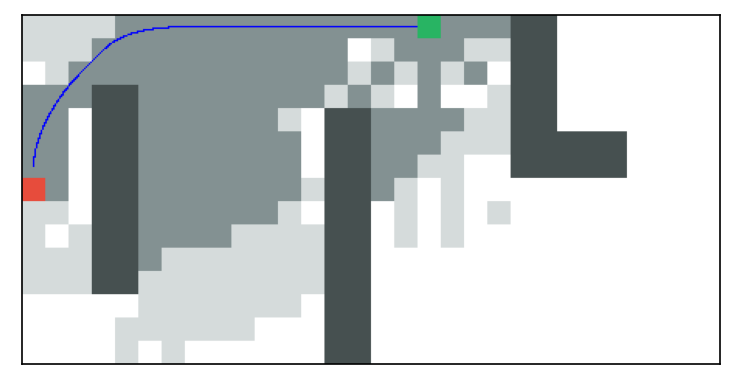

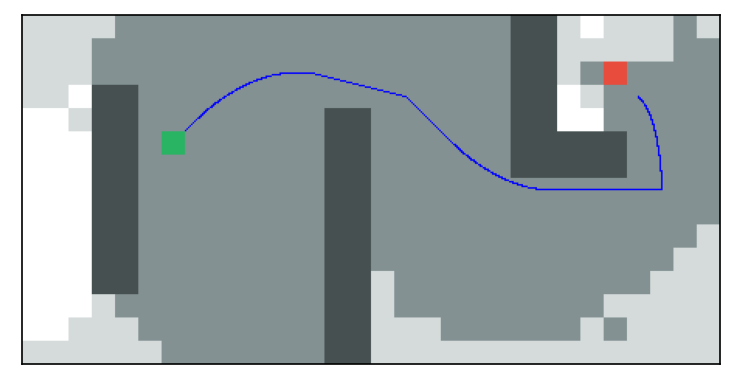

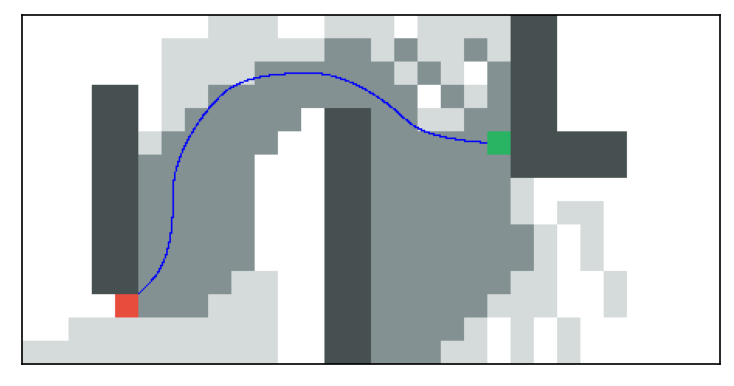

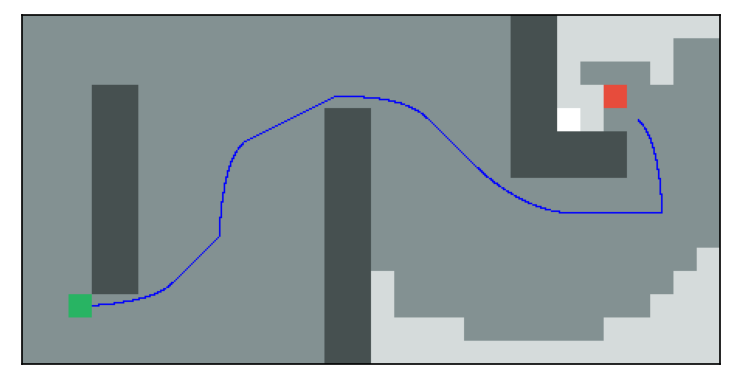

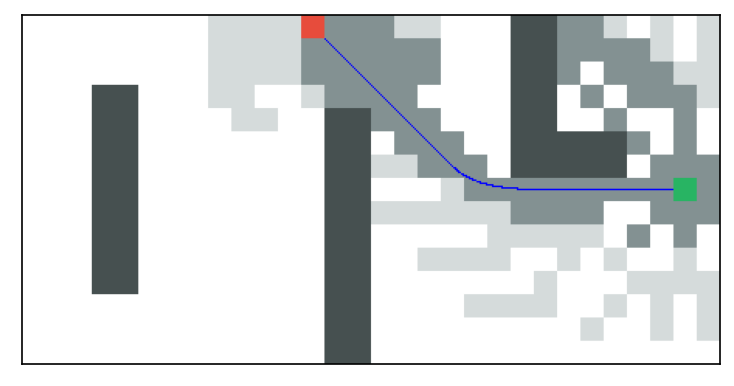

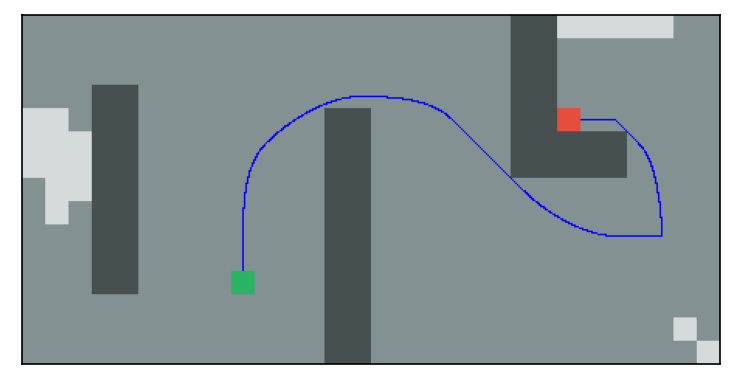

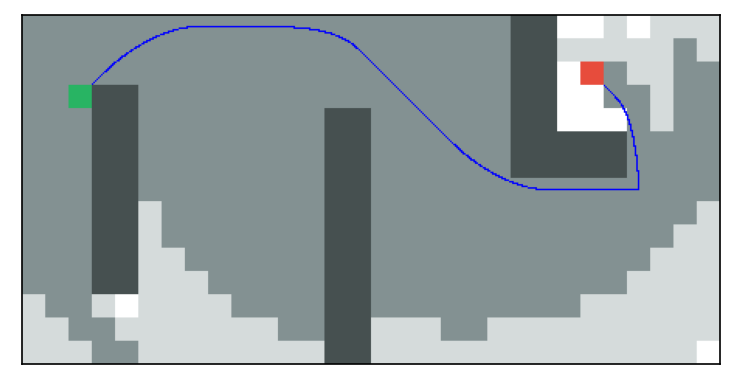

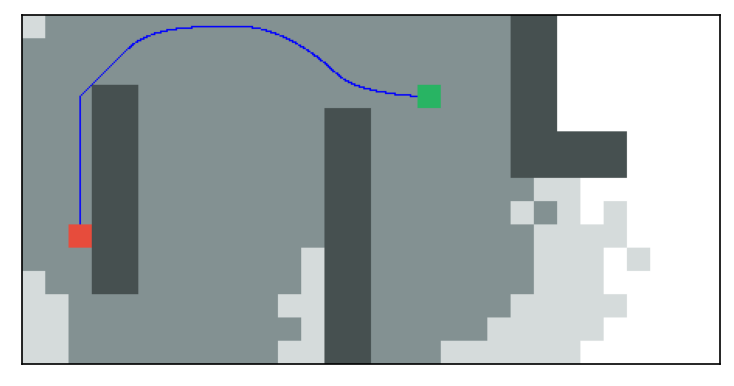

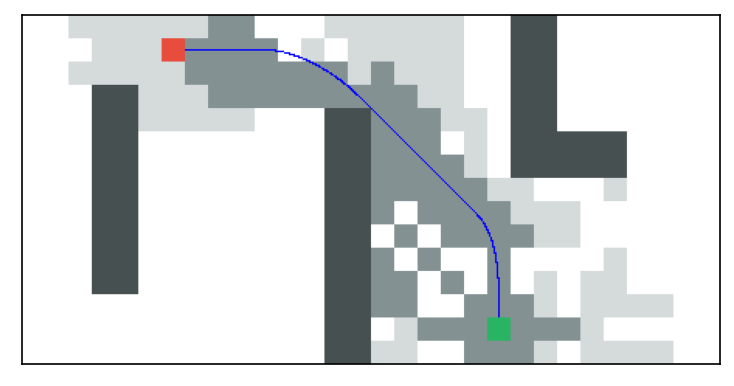

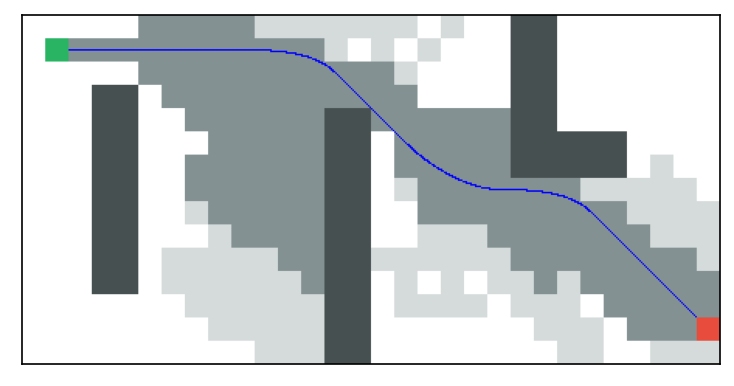

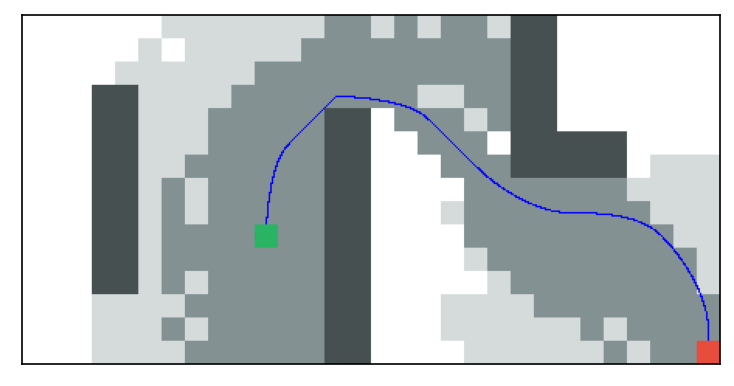

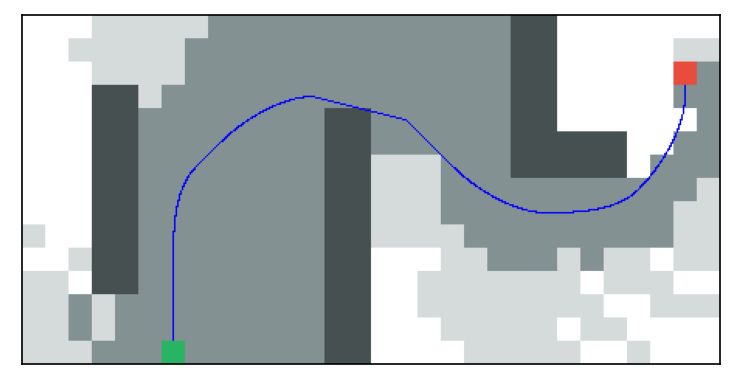

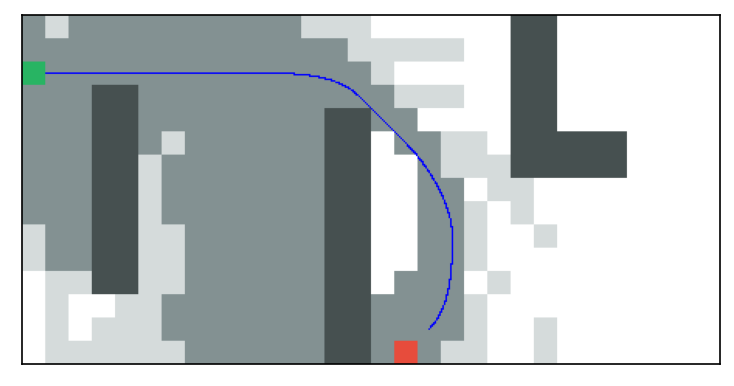

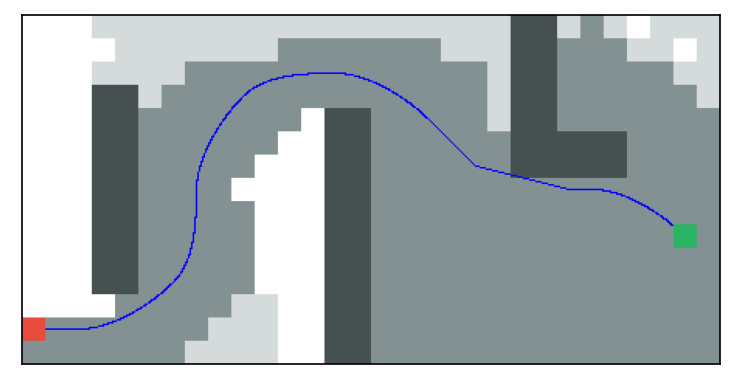

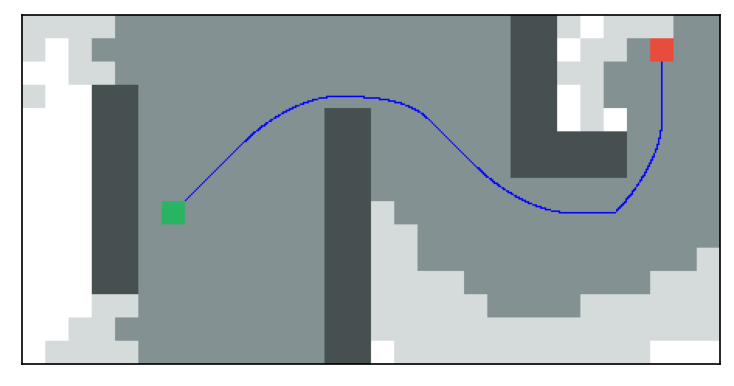

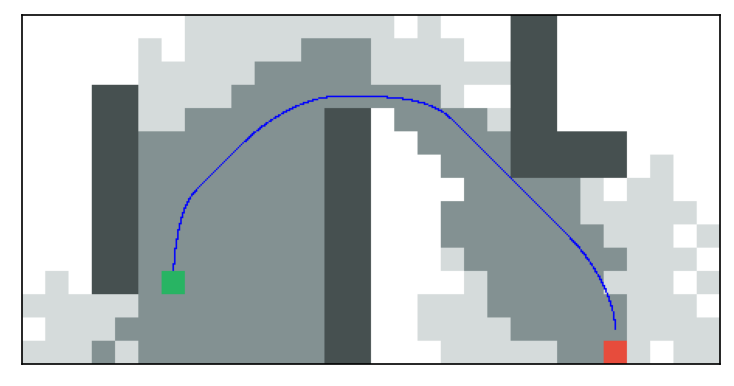

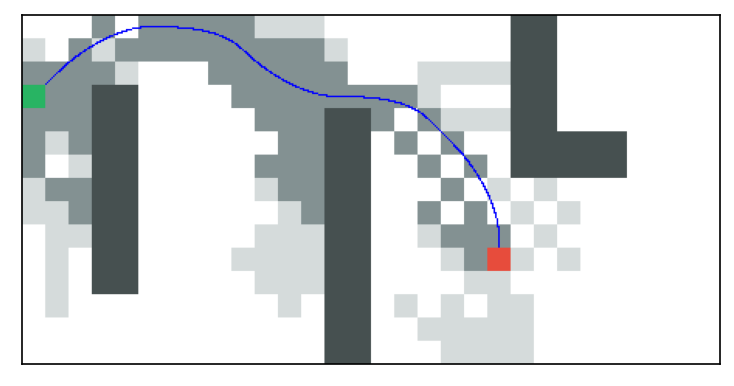

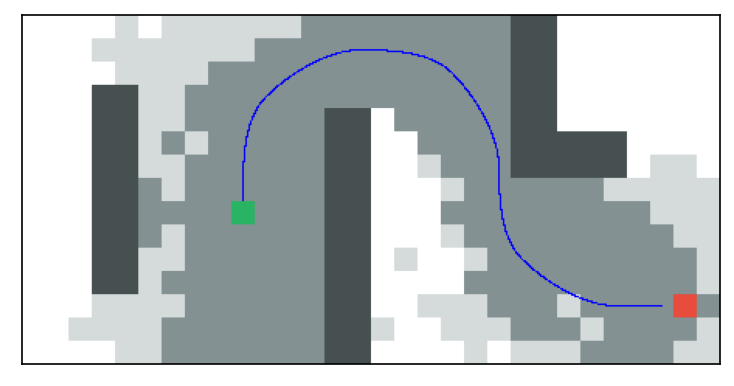

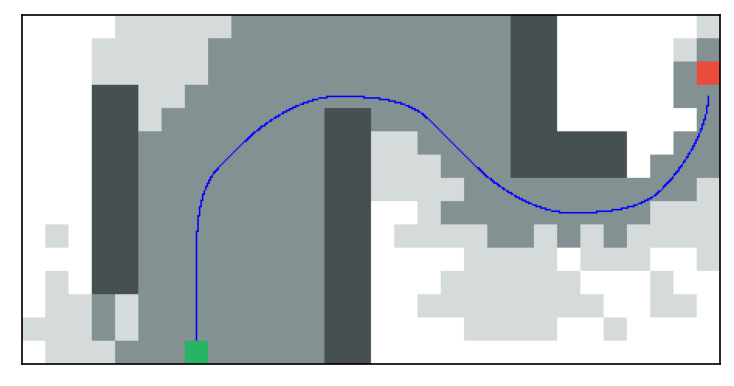

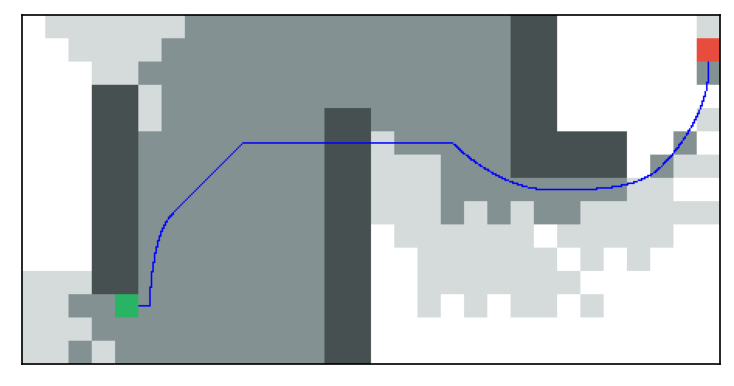

In [234]:
for i in range(25): 
  %time SimpleTest(WAStar, i, EuclideanDistance, YourOpen, YourClosed, primitives, 1.0)

In [ ]:
for i in range(25):
  %time SimpleTest(WAStar, 0, EuclideanDistance, YourOpen, YourClosed, primitives, 3.0)

In [238]:
#running massive test of A* with Euclidean-distance heuristic
%time astEuclidStat = MassiveTest(WAStar, EuclideanDistance, YourOpen, YourClosed, primitives, 1.0)

Path found! Length:  48.0000000000. Nodes created:     5125. Number of steps:     1537. Correct: True
Path found! Length: 179.9800000000. Nodes created:    70636. Number of steps:    66424. Correct: True
Path found! Length: 345.5376000000. Nodes created:   243912. Number of steps:   190107. Correct: True
Path found! Length: 374.9897000000. Nodes created:   374969. Number of steps:   360111. Correct: True
Path found! Length: 349.2500000000. Nodes created:   179849. Number of steps:    99004. Correct: True
Path found! Length: 315.5897000000. Nodes created:   151027. Number of steps:   124925. Correct: True
Path found! Length: 314.9876000000. Nodes created:   415944. Number of steps:   389917. Correct: True
Path found! Length: 441.8300000000. Nodes created:   373271. Number of steps:   325120. Correct: False
Path found! Length: 544.3376000000. Nodes created:   655048. Number of steps:   612078. Correct: False
CPU times: user 1h 6min 17s, sys: 11.9 s, total: 1h 6min 29s
Wall time: 1h 6min 

In [235]:
#running massive test of A* with Euclidean-distance heuristic inflated on the coefficient 0.8 to be optimal
%time astEuclidStat = MassiveTest(WAStar, EuclideanDistance, YourOpen, YourClosed, primitives, 0.8)

Path found! Length:  48.0000000000. Nodes created:    13183. Number of steps:     7784. Correct: True
Path found! Length: 179.9800000000. Nodes created:    92333. Number of steps:    86005. Correct: True
Path found! Length: 345.5376000000. Nodes created:   540032. Number of steps:   511259. Correct: True
Path found! Length: 374.9897000000. Nodes created:   456156. Number of steps:   441093. Correct: True
Path found! Length: 349.2500000000. Nodes created:   510224. Number of steps:   494040. Correct: True
Path found! Length: 315.5897000000. Nodes created:   300330. Number of steps:   281342. Correct: True
Path found! Length: 314.9876000000. Nodes created:   581630. Number of steps:   561691. Correct: True
Path found! Length: 441.2300000000. Nodes created:   715967. Number of steps:   683172. Correct: True
Path found! Length: 544.1376000000. Nodes created:  1165993. Number of steps:  1122678. Correct: True
CPU times: user 1h 30min 23s, sys: 18.7 s, total: 1h 30min 41s
Wall time: 1h 30min

In [45]:
#running massive test of weighted A* with Euclidean-distance heuristic and hweight = 2.0
%time astEuclidStat = MassiveTest(WAStar, EuclideanDistance, YourOpen, YourClosed, primitives, 2.0)

Path found! Length:  48.7376000000. Nodes created:      116. Number of steps:       21. Correct: False
Path found! Length: 196.1052000000. Nodes created:    37766. Number of steps:    32933. Correct: False
Path found! Length: 402.9752000000. Nodes created:    30757. Number of steps:    21321. Correct: False
Path found! Length: 406.8876000000. Nodes created:   229372. Number of steps:   220229. Correct: False
Path found! Length: 370.3252000000. Nodes created:     5704. Number of steps:     3439. Correct: False
Path found! Length: 327.0897000000. Nodes created:    53499. Number of steps:    45639. Correct: False
Path found! Length: 339.5252000000. Nodes created:    18339. Number of steps:    12801. Correct: False
Path found! Length: 512.8876000000. Nodes created:    55340. Number of steps:    43671. Correct: False
Path found! Length: 562.4376000000. Nodes created:    13716. Number of steps:     8388. Correct: False
CPU times: user 1min 39s, sys: 563 ms, total: 1min 40s
Wall time: 1min 44